CIFAR-10 CNN
========

CIFAR-10: https://www.cs.toronto.edu/~kriz/cifar.html

O conjunto de dados CIFAR-10 possui 600000 imagens coloridas de dimensões $32\times 32$. Os dados são divididos em 10 casses com 6000 imagens por classe. 

O exemplo abaixo é uma adaptação do exemplo fornecido na documentação do Keras: 
https://github.com/fchollet/keras/blob/master/examples/cifar10_cnn.py

No exemplo uma rede convolucional profunda é treinada. A perda logaritmica no conjunto de teste chega a 0.65 em 25 épocas e a 0.55 após 50 épocas.

Para mostrar os pesos da rede vonvolucional: https://github.com/fchollet/keras/issues/431
https://github.com/julienr/ipynb_playground/blob/master/keras/convmnist/keras_cnn_mnist.ipynb

Carregando e  mostrando os dados
==================


In [ ]:
%matplotlib inline
from __future__ import print_function
from keras.datasets import cifar10
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Convolution2D, MaxPooling2D
from keras.utils import np_utils
import matplotlib.pylab as plt
import cv2
import numpy as np

batch_size = 100
nb_classes = 10
nb_epoch = 50 #00
data_augmentation = True

# Dimensões das imagens
img_rows, img_cols = 32, 32
# Imagens RGB.
img_channels = 3

# varregando os dados
(X_train, y_train), (X_test, y_test) = cifar10.load_data()
y_train = y_train.ravel()
y_test = y_test.ravel()


#Selecionando apenas objetos das classes: 0, 1, 2, 3
indexes_train = (y_train == 0) | (y_train == 1) | (y_train == 2) | (y_train == 3)
X_train = X_train[indexes_train]
y_train = y_train[indexes_train]

indexes_test = (y_test == 0) | (y_test == 1) | (y_test == 2) | (y_test == 3)
X_test = X_test[indexes_test]
y_test = y_test[indexes_test]

print('X_train shape:', X_train.shape)
print(X_train.shape[0], 'amostras de treinamento')
print(X_test.shape[0], 'amostras de teste')

#Mostrando algumas imagens do conjunto de teste
plt.figure(figsize=(24, 12))
for k, i in enumerate(np.random.choice(np.arange(0, len(y_test)), size=(40,))):
    plt.subplot(5, 8, k + 1)
    image = (X_test[i]).transpose(2,0,1)
    image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
    cv2.putText(image, str(y_test[i]), (3, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.7, 
                (0, 255, 0), 2)

    # mostra as imagens
    plt.imshow(image,cmap = 'gray')
    plt.axis('off')
    
# Transforma o vetor de labes para o formato de one-hot encoding.
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

Construíndo a CNN com o Keras
==============================

In [ ]:
#Modelo sequencial
model = Sequential()

# Primeira convolução
conv1 = Convolution2D(3, 3, 3, border_mode='same',
                        input_shape=X_train.shape[1:])#32
print(X_train.shape[1:])
model.add(conv1)
convout1 = Activation('relu') 
model.add(convout1)


# #Segunda convolução
# model.add(Convolution2D(3, 3, 3))
# convout2 = Activation('relu')
# model.add(convout2)

# Primeiro Max-pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
maxpooling_out1 = Dropout(0.25)
model.add(maxpooling_out1)

# Terceira convolução
model.add(Convolution2D(2, 3, 3, border_mode='same'))
convout3 = Activation('relu') 
model.add(convout3)

# # Quarta convolução
# model.add(Convolution2D(64, 3, 3))
# convout4 = Activation('relu') 
# model.add(convout4)

# Segundo max-pooling
model.add(MaxPooling2D(pool_size=(2, 2)))
maxpooling_out2 = Dropout(0.25)
model.add(maxpooling_out2)

# Camadas finais
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

if not data_augmentation:
    print('Sem aumento de dados.')
    model.fit(X_train, Y_train,
              batch_size=batch_size,
              nb_epoch=nb_epoch,
              validation_data=(X_test, Y_test),
              shuffle=True)
else:
    print('Com aumento de dados.')
    # Pre-processamento e aumento de dados em tempo real:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # poe a media da entrada em 0 ao longo do dataset
        samplewise_center=False,  # poe a media de cada amostra em zero
        featurewise_std_normalization=False,  # normaliza pelo desvio padrão do dataset
        samplewise_std_normalization=False,  # normaliza pelo desvio padrão cada amostra
        zca_whitening=False,  # aplica "ZCA whitening"
        rotation_range=0,  # rotaciona as imagens aleatoriamente (0 a 180 graus)
        width_shift_range=0.1,  # aleatoriamente desloca a imagem horizontalmente (fração da largura)
        height_shift_range=0.1,  # aleatoriamente desloca a imagem certicalmente (fração da altura)
        horizontal_flip=True,  # espelha aleatoriamente as imagens na horizontal
        vertical_flip=False)  # espelha aleatoriamente as imagens na vertical

    # Cálcula os valores necessários para realizar a normalização por amostra
    # (desvio-padrão, Média, e componentes principais se for aplicado "ZCA whitening").
    datagen.fit(X_train)

    # Faz o treino do modelo nos batches gerados pelo datagen.flow().
    model.fit_generator(datagen.flow(X_train, Y_train,
                                     batch_size=batch_size),
                        samples_per_epoch=X_train.shape[0],
                        nb_epoch=nb_epoch,
validation_data=(X_test, Y_test))

(3, 32, 32)
Com aumento de dados.
Epoch 1/50
20000/20000 [==============================] - 13s - loss: 1.2695 - acc: 0.4251 - val_loss: 1.0841 - val_acc: 0.5370
Epoch 2/50
20000/20000 [==============================] - 12s - loss: 1.0859 - acc: 0.5324 - val_loss: 1.0166 - val_acc: 0.5773
Epoch 3/50
20000/20000 [==============================] - 12s - loss: 1.0237 - acc: 0.5671 - val_loss: 0.9910 - val_acc: 0.5892
Epoch 4/50
20000/20000 [==============================] - 12s - loss: 0.9820 - acc: 0.5828 - val_loss: 0.9570 - val_acc: 0.6045
Epoch 5/50
20000/20000 [==============================] - 12s - loss: 0.9606 - acc: 0.5894 - val_loss: 0.9503 - val_acc: 0.6075
Epoch 6/50
20000/20000 [==============================] - 12s - loss: 0.9399 - acc: 0.6061 - val_loss: 0.9361 - val_acc: 0.6030
Epoch 7/50
20000/20000 [==============================] - 12s - loss: 0.9318 - acc: 0.6073 - val_loss: 0.8857 - val_acc: 0.6305
Epoch 8/50
20000/20000 [==============================] - 12s - loss: 

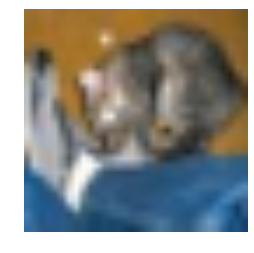

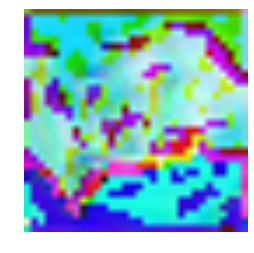

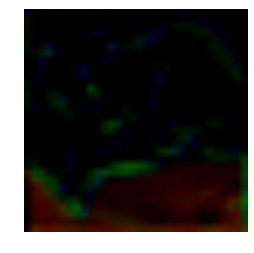

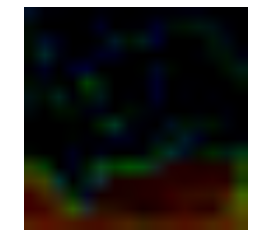

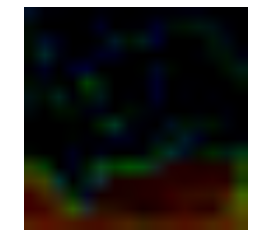

TypeError: Invalid dimensions for image data

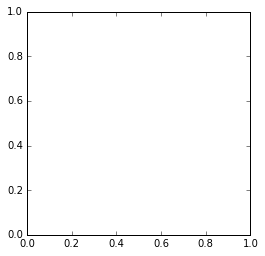

In [104]:
plt.imshow(X_test[0].transpose(1,2,0))
plt.axis('off')
    
plt.show()
for layer in model.layers:
    intermediate_layer_model = Model(input=model.input,output=layer.output)
    intermediate_output = intermediate_layer_model.predict(X_test[0].reshape(1,3,32,32))
    for kk in xrange(intermediate_output.shape[0]):
        aux = intermediate_output[kk,:,:]
        plt.imshow(aux.transpose(1,2,0),cmap ='gray')
    plt.axis('off')
    plt.show()
    

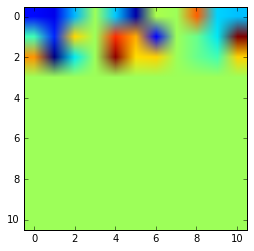

In [105]:
weights = conv1.get_weights()[0]
weightsR = weights[:,0,:,:]
weightsG = weights[:,1,:,:]
weightsB = weights[:,2,:,:]
#print(make_mosaic(weightsR, 3, 3, border=1).shape)
#for jj in xrange(32):
#    plt.imshow(weightsR[jj], cmap='gray')
#    plt.show()
    
plt.imshow(make_mosaic(weightsR, 3, 3, border=1))
plt.show()